# Assignment 2.1: Feed-Forward Neural Network
Student Name 1: Yassir Al Bahri

Student Name 2: Serena Alderisi

Student Name 3: Elisa Mateos Vicente

## German Traffic Sign Benchmark

In [2]:
from google.colab import drive
drive.mount('/GoogleDrive', force_remount=True)

!unzip '/GoogleDrive/My Drive/Colab Notebooks/FullIJCNN2013.zip'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /GoogleDrive
Archive:  /GoogleDrive/My Drive/Colab Notebooks/FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

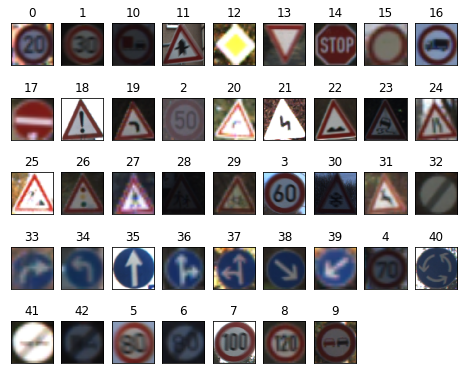

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [0]:

from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

# Normalize the images to be values in range [0, 1]
tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
# Converts a class vector (integers) to binary class matrix
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers
from keras.layers.normalization import BatchNormalization 

mlp = Sequential()

mlp.add(Flatten(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
mlp.add(Activation('elu'))

mlp.add(Dense(150))
mlp.add(BatchNormalization())
mlp.add(Activation('elu'))
mlp.add(Dropout(0.5))

mlp.add(Dense(150))
mlp.add(BatchNormalization())
mlp.add(Activation('elu'))
mlp.add(Dropout(0.5))

mlp.add(Dense(150))
mlp.add(BatchNormalization())
mlp.add(Activation('elu'))
mlp.add(Dropout(0.5))

mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 150528)            0         
_________________________________________________________________
activation_14 (Activation)   (None, 150528)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 150)               22579350  
_________________________________________________________________
batch_normalization_1 (Batch (None, 150)               600       
_________________________________________________________________
activation_15 (Activation)   (None, 150)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 150)              

In [0]:
data = mlp.fit(tr_signs, tr_labels, batch_size=50, epochs=200, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = mlp.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('ffNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/200
 - 4s - loss: 0.6887 - acc: 0.8017 - val_loss: 0.9646 - val_acc: 0.7579
Epoch 2/200
 - 4s - loss: 0.6692 - acc: 0.8367 - val_loss: 0.9320 - val_acc: 0.7778
Epoch 3/200
 - 4s - loss: 0.6120 - acc: 0.8617 - val_loss: 0.9247 - val_acc: 0.7659
Epoch 4/200
 - 4s - loss: 0.6567 - acc: 0.8300 - val_loss: 0.9060 - val_acc: 0.7698
Epoch 5/200
 - 4s - loss: 0.6177 - acc: 0.8533 - val_loss: 0.8887 - val_acc: 0.7897
Epoch 6/200
 - 4s - loss: 0.6635 - acc: 0.8117 - val_loss: 0.8738 - val_acc: 0.7976
Epoch 7/200
 - 4s - loss: 0.5955 - acc: 0.8467 - val_loss: 0.8794 - val_acc: 0.7937
Epoch 8/200
 - 4s - loss: 0.6473 - acc: 0.8217 - val_loss: 0.8919 - val_acc: 0.7738
Epoch 9/200
 - 4s - loss: 0.6002 - acc: 0.8450 - val_loss: 0.8611 - val_acc: 0.7857
Epoch 10/200
 - 4s - loss: 0.6148 - acc: 0.8400 - val_loss: 0.8910 - val_acc: 0.7738
Epoch 11/200
 - 4s - loss: 0.6088 - acc: 0.8450 - val_loss: 0.8586 - val_acc: 0.7937
Epoch 12/200
 - 4s - loss: 0

# CIFAR 100 Dataset

In [0]:
from keras.datasets import cifar100
(_x_train, _y_train), (_x_test, _y_test) = cifar100.load_data(label_mode='fine')


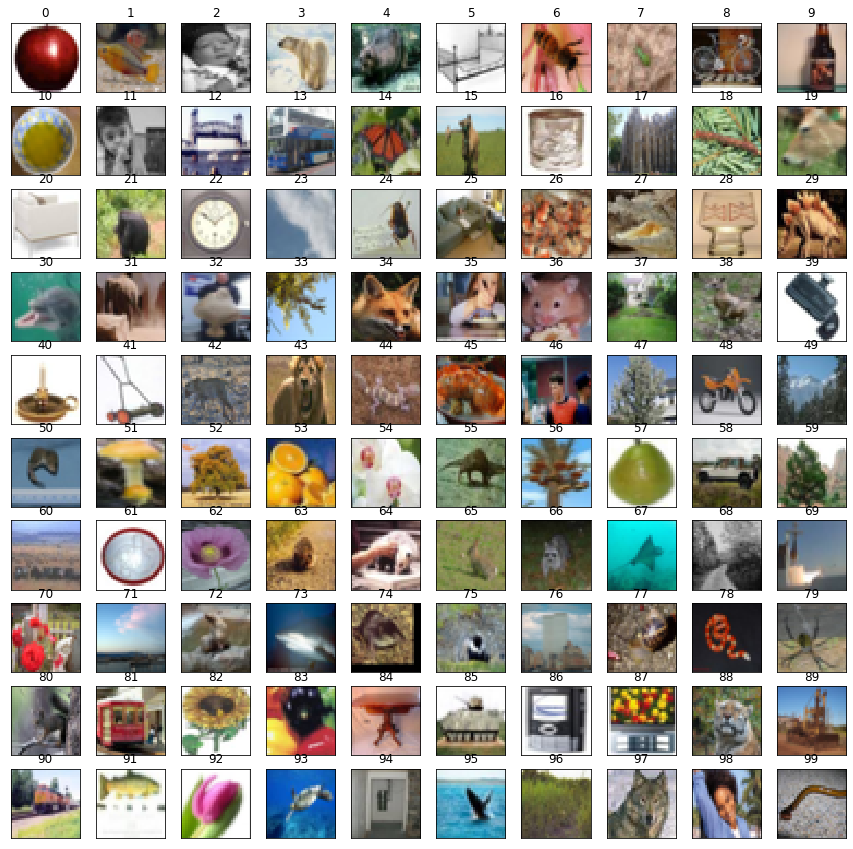

In [0]:
# Show examples from each class
class_names = np.unique(_y_train)
num_classes = len(class_names)

fig, axes = plt.subplots(10, 10,figsize=(15,15))
for i in range(num_classes):
    ax = axes.flatten()[i]
    indices = np.where(np.isin(_y_train, class_names[i]))[0]
    ax.imshow(_x_train[int(np.random.choice(indices, 1))])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(i)
plt.show()

In [0]:
# Data pre-processing
x_val = _x_train[40000:]
y_val = _y_train[40000:]
x_train = _x_train[:40000]
y_train = _y_train[:40000]
x_test = _x_test
y_test = _y_test

# Normalize the images to be values in range [0, 1]
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0

from keras.utils import np_utils
# Converts a class vector (integers) to binary class matrix
tr_labels = np_utils.to_categorical(y_train, num_classes)
va_labels = np_utils.to_categorical(y_val, num_classes)
te_labels = np_utils.to_categorical(y_test, num_classes)

CIFAR_SIZE = (32, 32)

In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [0]:
mlp = Sequential()

mlp.add(Flatten(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))


mlp.add(Dense(num_classes*2))
mlp.add(Activation('elu'))
mlp.add(Dropout(0.2))


mlp.add(Dense(num_classes*2))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))


mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
activation_3 (Activation)    (None, 3072)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               307300    
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
Total params: 307,300
Trainable params: 307,300
Non-trainable params: 0
_________________________________________________________________


In [0]:
data = mlp.fit(x_train, tr_labels, batch_size=16, epochs=100, verbose=2, validation_data=(x_val, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = mlp.evaluate(x_test, te_labels, verbose=0)
end = time()
print('ffNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
 - 4s - loss: 4.2624 - accuracy: 0.0662 - val_loss: 3.9853 - val_accuracy: 0.1028
Epoch 2/100
 - 4s - loss: 3.9695 - accuracy: 0.1136 - val_loss: 3.9057 - val_accuracy: 0.1230
Epoch 3/100
 - 4s - loss: 3.8716 - accuracy: 0.1281 - val_loss: 3.8685 - val_accuracy: 0.1250
Epoch 4/100
 - 4s - loss: 3.8132 - accuracy: 0.1407 - val_loss: 3.8225 - val_accuracy: 0.1353
Epoch 5/100
 - 4s - loss: 3.7702 - accuracy: 0.1488 - val_loss: 3.7897 - val_accuracy: 0.1454
Epoch 6/100
 - 4s - loss: 3.7361 - accuracy: 0.1578 - val_loss: 3.7769 - val_accuracy: 0.1450
Epoch 7/100
 - 4s - loss: 3.7139 - accuracy: 0.1600 - val_loss: 3.7667 - val_accuracy: 0.1524
Epoch 8/100
 - 4s - loss: 3.6849 - accuracy: 0.1665 - val_loss: 3.7923 - val_accuracy: 0.1543
Epoch 9/100
 - 4s - loss: 3.6722 - accuracy: 0.1678 - val_loss: 3.7378 - val_accuracy: 0.1588
Epoch 10/100
 - 5s - loss: 3.6481 - accuracy: 0.1702 - val_loss: 3.7602 - val_accuracy: 0.1524
Epoch 11/

Epoch 87/100
 - 4s - loss: 3.3867 - accuracy: 0.2227 - val_loss: 3.7237 - val_accuracy: 0.1695
Epoch 88/100
 - 4s - loss: 3.3843 - accuracy: 0.2239 - val_loss: 3.6957 - val_accuracy: 0.1728
Epoch 89/100
 - 4s - loss: 3.3866 - accuracy: 0.2211 - val_loss: 3.7382 - val_accuracy: 0.1636
Epoch 90/100
 - 4s - loss: 3.3788 - accuracy: 0.2238 - val_loss: 3.7297 - val_accuracy: 0.1648
Epoch 91/100
 - 4s - loss: 3.3816 - accuracy: 0.2218 - val_loss: 3.7465 - val_accuracy: 0.1623
Epoch 92/100
 - 4s - loss: 3.3821 - accuracy: 0.2222 - val_loss: 3.7563 - val_accuracy: 0.1598
Epoch 93/100
 - 4s - loss: 3.3833 - accuracy: 0.2229 - val_loss: 3.7390 - val_accuracy: 0.1656
Epoch 94/100
 - 4s - loss: 3.3787 - accuracy: 0.2239 - val_loss: 3.7080 - val_accuracy: 0.1668
Epoch 95/100
 - 4s - loss: 3.3791 - accuracy: 0.2246 - val_loss: 3.7268 - val_accuracy: 0.1651
Epoch 96/100
 - 4s - loss: 3.3734 - accuracy: 0.2258 - val_loss: 3.7212 - val_accuracy: 0.1660
Epoch 97/100
 - 4s - loss: 3.3778 - accuracy: 0.22